<a href="https://colab.research.google.com/github/ikoghoemmanuell/Grocery-Store-Forecasting-Challenge-For-Azubian/blob/main/dev/notebooks/sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Title

# Description

In [1]:
pip install category_encoders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import matplotlib.dates as mdates
%matplotlib inline
from itertools import product

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import AutoReg
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
import os
warnings.filterwarnings("ignore")
from google.colab import drive

# Data Loading

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the folder path in Google Drive where your CSV files are located
folder_path = "/content/drive/MyDrive/Colab Notebooks/datasets/grocery store azubian"

# Load the CSV files into DataFrames
data = {}

# Iterate over the files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        # Remove the file extension to get the variable name
        variable_name = file_name.replace(".csv", "")

        # Construct the file path
        file_path = os.path.join(folder_path, file_name)

        # Read the CSV file content into a DataFrame
        data[variable_name] = pd.read_csv(file_path)

# Access the data using dictionary keysdri
holidays = data["holidays"]
dates = data["dates"]
sample = data["SampleSubmission"]
stores = data["stores"]
test = data["test"]
train = data["train"]

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# train = pd.read_csv("C:/Users/LENOVO/Music/Grocery-Store-Forecasting-Challenge-For-Azubian/assets/grocery store azubian/train.csv")
# test = pd.read_csv("C:/Users/LENOVO/Music/Grocery-Store-Forecasting-Challenge-For-Azubian/assets/grocery store azubian/test.csv")
# stores = pd.read_csv("C:/Users/LENOVO/Music/Grocery-Store-Forecasting-Challenge-For-Azubian/assets/grocery store azubian/stores.csv")
# sample = pd.read_csv("C:/Users/LENOVO/Music/Grocery-Store-Forecasting-Challenge-For-Azubian/assets/grocery store azubian/SampleSubmission.csv")
# dates = pd.read_csv("C:/Users/LENOVO/Music/Grocery-Store-Forecasting-Challenge-For-Azubian/assets/grocery store azubian/dates.csv")
# holidays = pd.read_csv("C:/Users/LENOVO/Music/Grocery-Store-Forecasting-Challenge-For-Azubian/assets/grocery store azubian/holidays.csv")

# Dataset overview

In [6]:
train.head()

,date,store_id,category_id,target,onpromotion,nbr_of_transactions
0,365,store_1,category_24,0.0,0,0.0
1,365,store_1,category_21,0.0,0,0.0
2,365,store_1,category_32,0.0,0,0.0
3,365,store_1,category_18,0.0,0,0.0
4,365,store_1,category_26,0.0,0,0.0


train date is in numerical format. We'll have to convert it to Datetime format later

In [7]:
test.head()

,date,store_id,category_id,onpromotion
0,1627,store_1,category_24,0
1,1627,store_1,category_21,0
2,1627,store_1,category_32,0
3,1627,store_1,category_18,16
4,1627,store_1,category_26,0


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99792 entries, 0 to 99791
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         99792 non-null  int64 
 1   store_id     99792 non-null  object
 2   category_id  99792 non-null  object
 3   onpromotion  99792 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 3.0+ MB


In [9]:
stores.head()

,store_id,city,type,cluster
0,store_1,0,0,0
1,store_2,0,0,0
2,store_3,0,0,1
3,store_4,0,0,2
4,store_5,1,0,3


In [10]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   store_id  54 non-null     object
 1   city      54 non-null     int64 
 2   type      54 non-null     int64 
 3   cluster   54 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.8+ KB


city, type & cluster are categoric variables, so they are not supposed to be in number datatype(int64)

furthermore, cities do not have an ordinal relationship with one another. Ordinal variables have a natural order. Just like "good-better-best" or "positive-neutral-negative". Nominal variables don't.

We don't want our machine learning models to think that one city-0 comes before city-1, which is before city-3.

Therefore, we'll have to change the datatypes to obect or string to make it more descriptive, for example: 'London', 'Tokyo', 'Rome' and so on.

Same goes for type and cluster.

In [11]:
dates['date'].unique()

array([ 365,  366,  367, ..., 1682, 1683, 1684])

This dataset contains dates and the features that have already been extracted from it

In [12]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   date              1320 non-null   int64
 1   year              1320 non-null   int64
 2   month             1320 non-null   int64
 3   dayofmonth        1320 non-null   int64
 4   dayofweek         1320 non-null   int64
 5   dayofyear         1320 non-null   int64
 6   weekofyear        1320 non-null   int64
 7   quarter           1320 non-null   int64
 8   is_month_start    1320 non-null   bool 
 9   is_month_end      1320 non-null   bool 
 10  is_quarter_start  1320 non-null   bool 
 11  is_quarter_end    1320 non-null   bool 
 12  is_year_start     1320 non-null   bool 
 13  is_year_end       1320 non-null   bool 
 14  year_weekofyear   1320 non-null   int64
dtypes: bool(6), int64(9)
memory usage: 100.7 KB


in this case, these categories have an ordinal relationship with one another, meaning one date naturally comes before the other,

so we can leave them as they are.

In [13]:
dates.dayofyear.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

we have 365 days in a year, 366 days is for a loop year. This is a problem for us. Let me explain why.

**Problem**:
When you have a loop year, then new year's eve would fall on day 366

otherwise, it would fall on day 365. So everyday might not fall on the appropriate number for each year.

**Solution**:
we will later convert two new columns called "sin(dayofyear)" & "cos(dayofyear)". These new columns will help our machine learning models to understand the cyclic nature of a year.

Cyclic means that a year usually starts and ends in a similar way.

In [14]:
holidays.head()

,date,type
0,1,0
1,5,4
2,12,4
3,42,0
4,43,0


In [15]:
holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   date    281 non-null    int64
 1   type    281 non-null    int64
dtypes: int64(2)
memory usage: 4.5 KB


In [16]:
holidays.type.unique()

array([0, 4, 2, 5, 1, 3])

The type column is a categoric variable, and each type of holiday does not have an ordinal relationship, since a holiday like new year is not higher or better than Christmas for example.

so we'll later convert them to string type to make it more descriptive

In [17]:
train.describe()

,date,target,onpromotion,nbr_of_transactions
count,2.248884e+06,2.248884e+06,2.248884e+06,2.248884e+06
mean,9.955000e+02,3.932649e+02,3.142002e+00,1.573591e+03
std,3.643080e+02,1.174938e+03,1.343616e+01,1.027832e+03
min,3.650000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,6.800000e+02,0.000000e+00,0.000000e+00,9.440000e+02
50%,9.955000e+02,1.500000e+01,0.000000e+00,1.338000e+03
75%,1.311000e+03,2.230000e+02,1.000000e+00,1.979000e+03
max,1.626000e+03,1.247170e+05,7.410000e+02,8.359000e+03


train dates range from **365** to **1626**

In [18]:
test.describe()

,date,onpromotion
count,99792.000000,99792.000000
mean,1654.500000,7.274892
std,16.163311,18.504041
min,1627.000000,0.000000
25%,1640.750000,0.000000
50%,1654.500000,0.000000
75%,1668.250000,6.000000
max,1682.000000,591.000000


test dates range from **1627** to **1682**

this is a continuation from train. This makes sense since we are to predict future transactions based on past data

**note**: we will not be using transaction data to train our models, since transaction data was not provided for our test data.

In [19]:
dates.describe(),

(              date         year        month   dayofmonth    dayofweek  \
 count  1320.000000  1320.000000  1320.000000  1320.000000  1320.000000   
 mean   1024.500000     2.344697     6.124242    15.612121     2.996970   
 std     381.195488     1.059333     3.366835     8.798020     2.001135   
 min     365.000000     1.000000     1.000000     1.000000     0.000000   
 25%     694.750000     1.000000     3.000000     8.000000     1.000000   
 50%    1024.500000     2.000000     6.000000    15.500000     3.000000   
 75%    1354.250000     3.000000     9.000000    23.000000     5.000000   
 max    1684.000000     4.000000    12.000000    31.000000     6.000000   
 
          dayofyear   weekofyear      quarter  year_weekofyear  
 count  1320.000000  1320.000000  1320.000000      1320.000000  
 mean    170.871970    24.934848     2.384091       259.101515  
 std     102.870939    14.726066     1.094568       104.162039  
 min       1.000000     1.000000     1.000000       101.000000 

dates are from **365** till **1684** which covers the train and test dates

so, we'll be able to add the features from here to both the train and test data based on the date

In [20]:
 holidays.describe()

,date,type
count,281.000000,281.000000
mean,901.896797,1.402135
std,461.359327,1.996031
min,1.000000,0.000000
25%,540.000000,0.000000
50%,934.000000,0.000000
75%,1237.000000,2.000000
max,1684.000000,5.000000


In [21]:
# count the number of dates in the holidays dataset
holidays.date.nunique()

251

notice that the dates in the holiday dataset are not complete

so, we will later create a column for holidays in our train and test dataset based on the following logic:

if a date is in the holidays table, then its a holiday, else that date is not a holiday

## Hypothesis
**H0**: holidays have a big effect on sales, hence the sales data is seasonal.

**H1**: holidays don't affect sales, hence sales data is stationary.

## Questions

1. Is the train data complete?
2. Do we have seasonality in our sales?
3. Are there outliers in our dataset?
4. What is the difference between RMSLE, RMSE and MSE?

| Issues                                  | how we intend to solve them                                                                                                   |
|----------------------------------------|------------------------------------------------------------------------------------------------------------|
| 1. City, type & cluster in our stores dataset are mumerical | convert to string and make the categories more descriptive.                                            |
| 2. The dayofyear column in our dates dataset ranges from 1 to 366. This will make some days fall on the wrong number | find the sine and cosine of this column to represent the cyclic nature of a year. | We can also include weather conditions, holidays and events to this.                        |


# Data Cleaning

Here, we will prepare our data for Univariate and Bivariate analysis.

## Fixing our issues

1. City, type & cluster in our stores dataset are mumerical

Solution: convert to string and make the categories more descriptive.

**city**

In [22]:
stores.city.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21])

In [23]:
# using each city number as index,
# convert each city number to the corresponding city from a list of us_cities
stores.city = stores.city.apply(lambda x: 'city_'+ str(x))

In [24]:
stores.city.unique()

array(['city_0', 'city_1', 'city_2', 'city_3', 'city_4', 'city_5',
       'city_6', 'city_7', 'city_8', 'city_9', 'city_10', 'city_11',
       'city_12', 'city_13', 'city_14', 'city_15', 'city_16', 'city_17',
       'city_18', 'city_19', 'city_20', 'city_21'], dtype=object)

**type**

In [25]:
stores.type.unique()

array([0, 1, 2, 3, 4])

In [26]:
# convert each store_type number to the corresponding store_type from a list of grocery_store_types
stores.type = stores.type.apply(lambda x: 'store_'+ str(x))

In [27]:
stores.type.unique()

array(['store_0', 'store_1', 'store_2', 'store_3', 'store_4'],
      dtype=object)

**cluster**

In [28]:
stores.cluster.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [29]:
# convert each cluster number to the corresponding cluster from a list of us_cities
stores.cluster = stores.cluster.apply(lambda x: 'cluster_'+ str(x))

In [30]:
stores.cluster.unique()

array(['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4',
       'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9',
       'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13',
       'cluster_14', 'cluster_15', 'cluster_16'], dtype=object)

In [31]:
holidays.type.unique()

array([0, 4, 2, 5, 1, 3])

2. The dayofyear column in our dates dataset ranges from 1 to 366. This will make some days fall on the wrong number

Solution: find the sine and cosine of this column to represent the cyclic nature of a year. We can also include weather conditions, holidays and events to this.

In [32]:
dates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   date              1320 non-null   int64
 1   year              1320 non-null   int64
 2   month             1320 non-null   int64
 3   dayofmonth        1320 non-null   int64
 4   dayofweek         1320 non-null   int64
 5   dayofyear         1320 non-null   int64
 6   weekofyear        1320 non-null   int64
 7   quarter           1320 non-null   int64
 8   is_month_start    1320 non-null   bool 
 9   is_month_end      1320 non-null   bool 
 10  is_quarter_start  1320 non-null   bool 
 11  is_quarter_end    1320 non-null   bool 
 12  is_year_start     1320 non-null   bool 
 13  is_year_end       1320 non-null   bool 
 14  year_weekofyear   1320 non-null   int64
dtypes: bool(6), int64(9)
memory usage: 100.7 KB


In [33]:
# create new coolumns to represent the cyclic nature of a year
dates["sin(dayofyear)"] = np.sin(dates["dayofyear"])
dates["cos(dayofyear)"] = np.cos(dates["dayofyear"])

In [34]:
def get_datetime(df):
  # Create a new column combining the year, month, and day of the month in the desired format
  df['date_extracted'] = (
      dates['year'].astype(int).add(2000).astype(str) + '-' +
      dates['month'].astype(str).str.zfill(2) + '-' +
      dates['dayofmonth'].astype(str).str.zfill(2)
  )

get_datetime(dates)

### merging our data

In [35]:
stores.rename(  # rename type to store_type to make it more descriptive
      columns={'type': 'store_type'},
      inplace=True)
holidays.rename(  # rename type to holiday_type to make it more descriptive
      columns={'type': 'holiday_type'},
      inplace=True)
# make each holiday type a string
holidays['holiday_type'] = holidays['holiday_type'].apply(lambda x: 'holiday_' + str(x))

In [36]:
#merging train and test with stores dataset

def merge(df1, df2):
    merged_df = df1.merge(df2, how='left', on='date')

    return merged_df

def merge_stores(df1, df2):
    merged_df = df1.merge(df2, how='left', on='store_id')

    return merged_df

In [37]:
def get_is_holiday_column(df):
  df['holiday_type'] = df['holiday_type'].fillna('Workday')

  # create column to show if its a holiday or not (non-holidays are zeros)
  df['is_holiday'] = df['holiday_type'].apply(
      lambda x: False if x=='Workday'
      else True)

we did this so our non-holidays can be zeros

now we must merge holidays with the merged data

since non-holidays are zeros, we don't want our ML Models to think that non-holidays(zeros) have an ordinal relationship with other holidays(1,2,3,4,)

in other words, non-holidays(zeros) don't always come before holidays(1,2,3,4,)

so, we must create a new column to show whether or not.

In [38]:
train_merged = merge_stores(train, stores)
train_merged1 = merge(train_merged, holidays)
get_is_holiday_column(train_merged1)
train_merged2 = merge(train_merged1, dates)

test_merged = merge_stores(test, stores)
test_merged1 = merge(test_merged, holidays)
get_is_holiday_column(test_merged1)
test_merged2 = merge(test_merged1, dates)

In [39]:
train_merged2['holiday_type'].unique()

array(['holiday_0', 'Workday', 'holiday_2', 'holiday_5', 'holiday_1',
       'holiday_4', 'holiday_3'], dtype=object)

In [40]:
# Convert the column to datetime with errors='coerce'
train_merged2['date_ext'] = pd.to_datetime(train_merged2['date_extracted'], errors='coerce')

# Filter rows with NaT values and convert them to a list
invalid_dates = train_merged2.loc[train_merged2['date_ext'].isna(), 'date_extracted'].tolist()

print(invalid_dates) #get a list of invalid dates
print(list(set(invalid_dates))) #unique invalid dates
train_merged2.drop('date_ext', axis=1, inplace=True)

['2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003-02-29', '2003

since the only invalid date is 2003-02-29, then when converting to datetime,

we will first set invalid dates to NaT

then fill them with 2003-02-29

In [41]:
train_merged2['date_extracted'] = pd.to_datetime(train_merged2['date_extracted'], errors='coerce')
test_merged2['date_extracted'] = pd.to_datetime(test_merged2['date_extracted'])
train_merged2['date_extracted'].fillna('2003-02-29')

0          2001-01-01 00:00:00
1          2001-01-01 00:00:00
2          2001-01-01 00:00:00
3          2001-01-01 00:00:00
4          2001-01-01 00:00:00
                  ...         
2288083    2004-06-18 00:00:00
2288084    2004-06-18 00:00:00
2288085    2004-06-18 00:00:00
2288086    2004-06-18 00:00:00
2288087    2004-06-18 00:00:00
Name: date_extracted, Length: 2288088, dtype: object

In [42]:
def set_index(df):
  df.drop('date', inplace=True, axis=1)
  df.set_index('date_extracted', inplace=True)
set_index(train_merged2)
set_index(test_merged2)

## Drop Duplicates

In [43]:
train_merged2.drop_duplicates(inplace=True)
test_merged2.drop_duplicates(inplace=True)

In [44]:
train = train_merged2
test = test_merged2

## Impute Missing Values

In [45]:
print(train.isnull().sum())
print(test.isnull().sum())

store_id               0
category_id            0
target                 0
onpromotion            0
nbr_of_transactions    0
city                   0
store_type             0
cluster                0
holiday_type           0
is_holiday             0
year                   0
month                  0
dayofmonth             0
dayofweek              0
dayofyear              0
weekofyear             0
quarter                0
is_month_start         0
is_month_end           0
is_quarter_start       0
is_quarter_end         0
is_year_start          0
is_year_end            0
year_weekofyear        0
sin(dayofyear)         0
cos(dayofyear)         0
dtype: int64
store_id            0
category_id         0
onpromotion         0
city                0
store_type          0
cluster             0
holiday_type        0
is_holiday          0
year                0
month               0
dayofmonth          0
dayofweek           0
dayofyear           0
weekofyear          0
quarter             0
is_mont

# Exploratory Data Analysis: EDA

## Hypothesis Validation
**H0**: holidays have a big effect on sales, hence the sales data is seasonal.

**H1**: holidays don't affect sales, hence sales data is stationary.

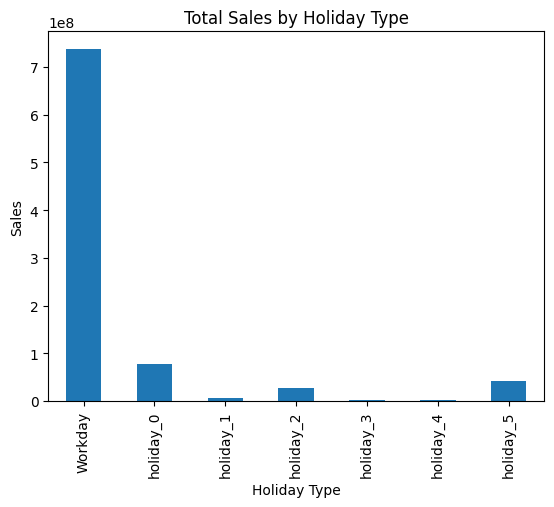

In [46]:
# Bar chart of sales by holiday type
train.groupby('holiday_type')['target'].sum().plot(kind='bar')
plt.xlabel('Holiday Type')
plt.ylabel('Sales')
plt.title('Total Sales by Holiday Type')
plt.show()

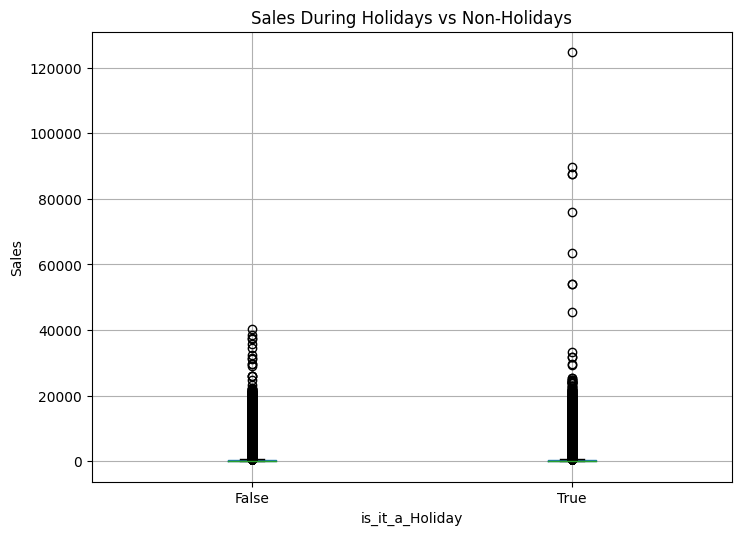

In [47]:
# Box plot of sales during holidays vs non-holidays
train.boxplot(column='target', by='is_holiday', figsize=(8, 6))
plt.xlabel('is_it_a_Holiday')
plt.ylabel('Sales')
plt.title('Sales During Holidays vs Non-Holidays')
plt.suptitle('')
plt.show()

## Answering Questions

1. Is the train data complete?

Yes. The output below shows that our train data is incomplete.

In [48]:
# create a function to check for missing extracted dates
def get_missing_dates(df):
  col = df.index
  missing_dates = (pd.date_range(

      start=col.min(), #start date
      end=col.max())   #end_date
      .difference(col))
  print(f"we have {len(missing_dates)} dates missing out of {len(col)}")
  return missing_dates

In [49]:
get_missing_dates(train)

we have 4 dates missing out of 2268486


DatetimeIndex(['2001-12-25', '2002-12-25', '2003-12-25', '2004-02-29'], dtype='datetime64[ns]', freq=None)

In [50]:
get_missing_dates(test)

we have 0 dates missing out of 99792


DatetimeIndex([], dtype='datetime64[ns]', freq=None)

2. Do we have seasonality in our sales?

In [51]:
# Assuming your time series data is stored in the variable 'sales_data'
sales_data = train['target']

In [52]:
# Perform KPSS test
kpss_result = kpss(sales_data)
kpss_statistic = kpss_result[0]
kpss_pvalue = kpss_result[1]
kpss_critical_values = kpss_result[3]

In [53]:
print("\nKPSS Test:")
print("KPSS Statistic:", kpss_statistic)
print("p-value:", kpss_pvalue)


KPSS Test:
KPSS Statistic: 64.852344099289
p-value: 0.01


stationary if p-value > 0.05

series is stationary since 0.01 < 0.05

In [ ]:
def check_stationarity(df, date_col, target_col, window=12):
    # Calculate rolling statistics
    rolling_std = df[target_col].rolling(window=window).std()
    rolling_mean = df[target_col].rolling(window=window).mean()

    # Plot original series and rolling statistics
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[target_col], color='blue', label='Original Series')
    plt.plot(df.index, rolling_std, color='green', label='Rolling Std')
    plt.plot(df.index, rolling_mean, color='red', label='Rolling Mean')
    plt.legend()
    plt.title('Rolling Statistics')
    plt.xlabel('Date')
    plt.ylabel('Target(sales)')
    plt.tight_layout()  # Adjusts plot spacing
    plt.show()

# Example usage
df = sales_data  # Assuming the sales data is stored in a dataframe called sales_data
target_col = 'sales'  # Column containing the sales data

check_stationarity(train, 'date_extracted', 'target')

### Checking for Stationarity of the Train Dataset

In [ ]:
# Perform seasonal decomposition
result = seasonal_decompose(train['target'], model='additive', period=12)  # Adjust the period as needed

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8))
result.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
result.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
result.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
result.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.tight_layout()
plt.show()

Observed values: These are the actual values of the time series. They represent the data points that are observed or recorded over a period of time. In the context of sales data, the observed values would be the actual sales figures recorded at different time intervals.

Trend: The trend component represents the long-term pattern or direction of the time series. It captures the underlying growth or decline in the data over an extended period. The trend component helps identify whether the series is increasing, decreasing, or remaining relatively stable over time.

Seasonal: The seasonal component represents the periodic patterns or fluctuations that occur within a time series. It captures the regular and repetitive variations that happen within specific time periods, such as daily, weekly, monthly, or yearly cycles. In sales data, seasonal patterns may include higher sales during holiday seasons or lower sales during certain months of the year.

Residual: The residual component, also known as the irregular or random component, represents the remaining variation in the time series after removing the trend and seasonal components. It includes any unpredictable or random fluctuations that are not accounted for by the trend or seasonal patterns. The residual component is often assumed to be noise or measurement error.

In [ ]:
def time_plot(data, y_col, title):
    fig, ax = plt.subplots(figsize=(15,5))
    data.resample('M')[y_col].sum().plot(ax=ax, color='mediumblue', label='Total Sales')
    data.resample('M')[y_col].mean().plot(ax=ax, color='red', label='Mean Sales')

    ax.set(xlabel="Date",
           ylabel="Sales",
           title=title)

    ax.legend()
    sns.despine()

# Example usage with your specific details
time_plot(train, 'target', 'Monthly Sales Over the Years')

3. Are there outliers in our dataset?

4. What is the difference between RMSLE, RMSE and MSE?

## Univariate Analysis

## Bivariate Analysis

In [ ]:
# Calculate the correlation matrix
correlation_matrix = train.corr()

# Find the moderately correlated variables
moderate_correlation = (correlation_matrix.abs() > 0.5) & (correlation_matrix != 1) & (correlation_matrix <0.8)

# Get the variable pairs with moderate correlation
moderate_correlation_pairs = [(i, j) for i in moderate_correlation.columns for j in moderate_correlation.columns if moderate_correlation.loc[i, j]]

# Print the moderately correlated variables
for pair in moderate_correlation_pairs:
    var1, var2 = pair
    correlation_value = correlation_matrix.loc[var1, var2]
    print(f"{var1} and {var2} are moderately correlated (correlation value: {correlation_value})")

These columns are all boolean, so let's look at others

In [ ]:
# Set the threshold for high correlation
threshold = 0.8

# Find the highly correlated variables
high_correlation = (correlation_matrix.abs() > threshold) & (correlation_matrix != 1)

# Get the variable pairs with high correlation
high_correlation_pairs = [(i, j) for i in high_correlation.columns for j in high_correlation.columns if high_correlation.loc[i, j]]

# Print the highly correlated variables
for pair in high_correlation_pairs:
    var1, var2 = pair
    correlation_value = correlation_matrix.loc[var1, var2]
    print(f"{var1} and {var2} are highly correlated (correlation value: {correlation_value})")

In [ ]:
# Specify the column pairs and their correlation values
column_pairs = [('year', 'year_weekofyear', 0.9884229388238451),
                ('month', 'dayofyear', 0.9964919406599103),
                ('month', 'weekofyear', 0.9658303008707717),
                ('month', 'quarter', 0.9713815220940318),
                ('dayofyear', 'month', 0.9964919406599103),
                ('dayofyear', 'weekofyear', 0.9669203951023091),
                ('dayofyear', 'quarter', 0.9685365398989686),
                ('weekofyear', 'month', 0.9658303008707717),
                ('weekofyear', 'dayofyear', 0.9669203951023091),
                ('weekofyear', 'quarter', 0.9426460215490194),
                ('quarter', 'month', 0.9713815220940318),
                ('quarter', 'dayofyear', 0.9685365398989686),
                ('quarter', 'weekofyear', 0.9426460215490194),
                ('year_weekofyear', 'year', 0.9884229388238451)]

# Create a grid layout for the scatter plots
num_pairs = len(column_pairs)
num_cols = 3  # Number of columns in the grid layout
num_rows = (num_pairs + num_cols - 1) // num_cols  # Number of rows in the grid layout

fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Create scatter plots for each column pair
for i, pair in enumerate(column_pairs):
    x_col, y_col, correlation_value = pair
    row = i // num_cols
    col = i % num_cols

    # Select the appropriate subplot for the scatter plot
    ax = axes[row, col] if num_rows > 1 else axes[col]

    # Create the scatter plot
    ax.scatter(train[x_col], train[y_col], alpha=0.5)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_title(f"Scatter plot: {x_col} vs {y_col}\nCorrelation value: {correlation_value:.4f}")

# Adjust the spacing between subplots
fig.tight_layout()

# Display the grid of scatter plots
plt.show()

Let's leave these because more date_features will help our ML models accuracy in this case

In [ ]:
# First format how figures apper in the notebook
pd.options.display.float_format = '{:.2f}'.format

**Summary of Our Sales and Number of Transactions**

In [ ]:
# Calculate summary statistics
summary_stats = train[['target', 'nbr_of_transactions']].describe()
print(summary_stats)

**Histogram of Sales**

In [ ]:
# Histogram of 'target'
train['target'].plot(kind='hist')
plt.xlabel('Target')
plt.ylabel('Frequency')
plt.title('Distribution of Target')
plt.show()

**Correlation Between Sales and number of Transactions**

In [ ]:
# Correlation matrix
corr_matrix = train[['target', 'nbr_of_transactions']].corr()
print(corr_matrix)

# Scatter plot
plt.scatter(train['target'], train['nbr_of_transactions'])
plt.xlabel('Target')
plt.ylabel('Number of Transactions')
plt.title('Scatter Plot of Target vs Number of Transactions')
plt.show()

The correlation coefficient between 'target' and 'nbr_of_transactions' is 0.24. This indicates a positive correlation between the two variables, but the correlation is relatively weak.

It suggests that there is a weak tendency for the 'target' and 'nbr_of_transactions' to increase together, but the relationship is not very strong.

Therefore, based on the correlation coefficient of 0.24, there is a weak positive correlation between the 'target' and 'nbr_of_transactions' columns in our dataset.

**Observing Sales over time**

In [ ]:
# Line plot of sales over time
train['target'].plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Sales Over Time')
plt.show()

In [ ]:
# Resample the data by day and calculate the total sales for each day
sales_daily = train['target'].resample('D').sum()

# Create a line plot of the "sales" column
plt.plot(sales_daily.index, sales_daily)

# Set the title and axis labels
plt.title("Total Sales by Day")
plt.xlabel("Date")
plt.ylabel("Total Sales")

# Display the plot
plt.show()

**Holiday Impact on Sales**

In [ ]:
# Bar chart of sales by holiday type
train.groupby('holiday_type')['target'].sum().plot(kind='bar')
plt.xlabel('Holiday Type')
plt.ylabel('Sales')
plt.title('Total Sales by Holiday Type')
plt.show()

In [ ]:
# Box plot of sales during holidays vs non-holidays
train.boxplot(column='target', by='is_holiday', figsize=(8, 6))
plt.xlabel('is_it_a_Holiday')
plt.ylabel('Sales')
plt.title('Sales During Holidays vs Non-Holidays')
plt.suptitle('')
plt.show()

**Stores Performance**

In [ ]:
# Bar chart of sales by store
train.groupby('store_id')['target'].sum().plot(kind='bar')
plt.xlabel('Store ID')
plt.ylabel('Sales')
plt.title('Total Sales by Store')
plt.show()

In [ ]:
# Bar chart of sales by category
train.groupby('category_id')['target'].sum().plot(kind='bar')
plt.xlabel('Category ID')
plt.ylabel('Sales')
plt.title('Total Sales by Category')
plt.show()

**Promotion Analysis**

In [ ]:
# Separate data for promotion and non-promotion
promotion_data = train[train['onpromotion'] == 1]
non_promotion_data = train[train['onpromotion'] == 0]

# Calculate average sales per day for promotion and non-promotion
promotion_avg_sales = promotion_data.groupby(promotion_data.index)['target'].mean()
non_promotion_avg_sales = non_promotion_data.groupby(non_promotion_data.index)['target'].mean()

# Line plot of average sales with and without promotion
plt.plot(promotion_avg_sales.index, promotion_avg_sales, label='Promotion', color='blue')
plt.plot(non_promotion_avg_sales.index, non_promotion_avg_sales, label='No Promotion', color='red')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.title('Average Sales with and without Promotion Over Time')
plt.legend()
plt.show()

**Monthly Statistics**

In [ ]:
# Filter data for the period from 2001 to 2003
# sales_2001_to_2003 = train['2001':'2003']

# Group by month and calculate sum of sales
monthly_sales = train.groupby(train.index.month)['target'].sum()

# Find the month with the highest sales
highest_sales_month = monthly_sales.idxmax()

# Print the month with the highest sales
print("The month with the highest sales is:", highest_sales_month)

In [ ]:
# Filter data for the period from 2001 to 2003
# sales_2001_to_2003 = train['2001':'2003']

# Group by month and calculate sum of sales
monthly_sales = train.groupby(train.index.month)['target'].sum()

# Find the month with the lowest sales
lowest_sales_month = monthly_sales.idxmin()

# Print the month with the lowest sales
print("The month with the lowest sales is:", lowest_sales_month)

In [ ]:
# Resample to monthly frequency and calculate sum of sales
monthly_sales = train['target'].resample('M').sum()

# Plot the monthly sales data
monthly_sales.plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Sales Over the Years')
plt.show()

## Multivariate Analysis

# Feature Engineering

## Creating New Features

In [ ]:
def getDateFeatures(df):

    df["is_weekend"] = df["dayofweek"] > 4

    # Define the criteria for each season
    seasons = {'Winter': [12, 1, 2], 'Spring': [3, 4, 5], 'Summer': [6, 7, 8], 'Autumn': [9, 10, 11]}

    # Create the 'season' column based on the 'date' column
    df['season'] = df["month"].map({month: season for season, months in seasons.items() for month in months})

    return df

In [ ]:
getDateFeatures(train)
getDateFeatures(test)

## Features Encoding & scaling

In [ ]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categoric_columns = train.select_dtypes(include=['object', 'category']).columns.tolist()

In [ ]:
numeric_columns.remove('target')
numeric_columns.remove('nbr_of_transactions')
print(numeric_columns)

In [ ]:
encoder = BinaryEncoder(drop_invariant=False, return_df=True,)
encoder.fit(train[categoric_columns])

In [ ]:
scaler = StandardScaler()
scaler.set_output(transform="pandas")
scaler.fit(train[numeric_columns])

In [ ]:
# import pickle

# with open('encoder.pkl', 'wb') as f:
#     pickle.dump(encoder, f)

# with open('scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

In [ ]:
scaled_num = scaler.transform(train[numeric_columns])
scaled_num_test = scaler.transform(test[numeric_columns])

In [ ]:
encoded_cat = encoder.transform(train[categoric_columns])
encoded_cat_test = encoder.transform(test[categoric_columns])

In [ ]:
train = pd.concat([scaled_num, encoded_cat, train['target']], axis=1)
test = pd.concat([scaled_num_test, encoded_cat_test], axis=1)

## Resampling

In [ ]:
resampled = train.resample('W').sum()
resampled_test = test.resample('W').sum()
train = resampled
test = resampled_test

**dataframe for the traditional time series models**

In [ ]:
train1 = train[['target']].copy()

In [ ]:
train1.head()

In [ ]:
# trainn, evall = train[172:], train[:172]

In [ ]:
# Split data into parts
x = train.drop(['target'], axis = 1)
y = train['target']

In [ ]:
len(train)-len(test)

In [ ]:
# Split data into Train Test
X_train, X_test, y_train, y_test = x[172:], x[:172], y[172:], y[:172]

In [ ]:
x.columns

# Machine Learning Modeling

# Traditional Machine Learning Models

## AR

In [ ]:
xx=train1['target']
x_train, x_test = xx[:172], xx[172:]
print(f'train len: {len(x_train)}, test len: {len(x_test)}')

In [ ]:
pacf = plot_pacf(x_train,lags = 20)

In [ ]:
armodel = AutoReg(x_train, lags = 3).fit()

In [ ]:
pred = armodel.predict(
    start=len(x_train),
    end=len(x)-1,
    dynamic = False
)
pred

In [ ]:
plt.plot(pred)
plt.plot(x_test, color='red')

In [ ]:
mse = mean_squared_error(x_test, pred )
msle = mean_squared_log_error(x_test, pred)
rmse = np.sqrt(mean_squared_error(x_test, pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(x_test, pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
results = pd.DataFrame([['AR', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = results.append(model_results, ignore_index = True)
results

## ARIMA

In [ ]:
stepwise_fit = auto_arima(x_train, trace = True, suppress_warnings = True)
stepwise_fit.summary()

In [ ]:
model = ARIMA(x_train, order=(2,1,2))
model_fit = model.fit()
model_fit.summary()

In [ ]:
# Make predictions on the test data
ARIMA_pred = model_fit.predict(
    start=len(x_train),
    end=len(x)-1,
    typ="levels")
ARIMA_pred

In [ ]:
plt.plot(ARIMA_pred)
plt.plot(x_test, color='red')

In [ ]:
# Evaluate our models
mse = mean_squared_error(x_test, ARIMA_pred)
msle = mean_squared_log_error(x_test, ARIMA_pred)
rmse = np.sqrt(mean_squared_error(x_test, ARIMA_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(x_test, ARIMA_pred)).round(2)

model_results = pd.DataFrame([['ARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

## SARIMA

In [ ]:
model = SARIMAX(x_train, order=(2, 1, 2), seasonal_order=(0,0,0,0))
model_fit = model.fit()
model_fit.summary()

In [ ]:
# Make predictions on the test data
SARIMA_pred = model_fit.predict(
    start=len(x_train),
    end=len(x)-1,
    typ="levels")
SARIMA_pred

In [ ]:
plt.plot(SARIMA_pred)
plt.plot(x_test, color='red')

In [ ]:
# Evaluate our models
mse = mean_squared_error(x_test, SARIMA_pred)
msle = mean_squared_log_error(x_test, SARIMA_pred)
rmse = np.sqrt(mean_squared_error(x_test, SARIMA_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(x_test, SARIMA_pred)).round(2)

model_results = pd.DataFrame([['SARIMA', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

## Backtest for Classical Models

In [ ]:
backtests = {
    1: ('2004-04-17', '2004-06-05'),
    2: ('2004-04-24', '2004-06-12'),
    3: ('2004-05-01', '2004-06-19')
}

In [ ]:
scores = {}

for idx, period in enumerate(backtests):
    _train = train1.reset_index()[train1.reset_index()['date_extracted'] < backtests[period][0]]
    _test = train1.reset_index()[(train1.reset_index()['date_extracted'] >= backtests[period][0]) & (train1.reset_index()['date_extracted'] <= backtests[period][1])]

    Xtrain = _train.target.values
    Xtest = _test.target.values

    model = ARIMA(Xtrain, order=(2, 1, 2))
    model_fit = model.fit()  # Fit the ARIMA model to the training data
    ypred = model_fit.predict(start=len(_train), end=len(_train) + len(_test) - 1, typ="levels")

    scores[period] = np.sqrt(mean_squared_error(Xtest, ypred))

print(scores)


# Non-Traditional Time Series Models

### DecisionTreeRegressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
tree = DecisionTreeRegressor()
model_tree = tree.fit(X_train, y_train)

# Make prediction on X_test
tree_pred = model_tree.predict(X_test)

In [ ]:
# feature importance for decision tree
plt.figure(figsize=(12,7))
plt.barh(X_train.columns, model_tree.feature_importances_)

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(y_test, label ='Actual Sales')
plt.plot(tree_pred, label='DecisionTreeRegressor')
plt.legend(loc='best')
plt.title('DecisionTreeRegressor Prediction')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, tree_pred )
rmse = np.sqrt(mean_squared_error(y_test, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, tree_pred)).round(2)
msle = mean_squared_log_error(y_test, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
# results = results.append(model_results, ignore_index = True)
results

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=1)
# fit model no training data
neigh.fit(X_train, y_train)

# make predictions for test data
neigh_pred = neigh.predict(X_test)

In [ ]:
mse = mean_squared_error(y_test, neigh_pred )
msle = mean_squared_log_error(y_test, neigh_pred)
rmse = np.sqrt(mean_squared_error(y_test, neigh_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y_test, neigh_pred)).round(5)

# model_results = pd.DataFrame([['lightGBM', mse, rmse]], columns = ['Model', 'MSE', 'RMSE'])
model_results = pd.DataFrame([['KNN', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results = results.append(model_results, ignore_index = True)
results

# Models Comparison

# Model Evaluation (Backtests)

In [ ]:
backtests = {m
    1: ('2017-07-01', '2017-07-15'),
    2: ('2017-07-15', '2017-07-30'),
    3: ('2017-08-01', '2017-08-15')
}

In [ ]:
# Backtests with Decision Tree
scores = {}

for idx, period in enumerate(backtests):

    _train = trainn.reset_index()[trainn.reset_index()['date'] < backtests[period][0]]
    _test = trainn.reset_index()[(trainn.reset_index()['date'] >= backtests[period][0]) & (trainn.reset_index()['date'] <= backtests[period][1])]

    Xtrain, ytrain = _train.set_index(['date']).drop(columns=['sales']).values, _train.sales.values
    Xtest, ytest = _test.set_index(['date']).drop(columns=['sales']).values, _test.sales.values

    lgbm_model = DecisionTreeRegressor().fit(Xtrain, ytrain)

    ypred = lgbm_model.predict(Xtest)

    scores[period] = np.sqrt(mean_squared_log_error(ytest, ypred))

print(scores)

In [ ]:
# Split data into parts
x = evall.drop(['sales'], axis = 1)
y = evall['sales']

In [ ]:
# Make prediction on X_test
tree_pred = neigh.predict(x)

In [ ]:
mse = mean_squared_error(y, tree_pred )
rmse = np.sqrt(mean_squared_error(y, tree_pred )).round(2)
rmsle = np.sqrt(mean_squared_log_error(y, tree_pred)).round(6)
msle = mean_squared_log_error(y, tree_pred).round(2)


results = pd.DataFrame([['DecisionTree', mse, msle, rmse, rmsle]], columns = ['Model', 'MSE', 'MSLE', 'RMSE', 'RMSLE'])
results

### predicting sales in our test

In [ ]:
# test_pred = armodel.predict(merged3_test_resampled)
test_pred = armodel.predict(
    start=len(x),
    end=len(x)+ len(test_date) -1,
    dynamic=False
)
test_pred[np.isnan(test_pred)] = 0
test_pred

In [ ]:
test_sales = pd.DataFrame(test_pred, columns=['sales'])
test_sales.head(30)

In [ ]:
# Save sample submission
# test_sales[[ 'sales']].to_csv('submission.csv', index=False)